This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/models.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [1]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    %pip install torchinfo
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [2]:
import math
import numpy as np
import pandas as pd

from pathlib import Path
from typing import Tuple
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [3]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Odometry

In [4]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-1"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
VALIDATION_FOLDER = EXPERIMENT_FOLDER / 'validation-recordings'
MODELS_FOLDER = Path().resolve().parent / 'models'
print(MODELS_FOLDER)

C:\Users\esdan\Desktop\AO\models


## Generate recording ground truth

The recording is composed by audio files from several devices that span for the
whole experiment and several wheel test bed control files that span for certain
parts of the experiment. In this section we combine the control files in order
to generate a unique ground truth for the whole recording.

In [5]:
recording = VALIDATION_FOLDER / 'date_2022-05-20;time_16-59-56'

def get_recording_bounds(recording: Path) -> Tuple[float, float]:
    start_timestamp = np.Inf
    end_timestamp = 0
    for wav_file in recording.glob('microphone*.wav'):
        config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
        start_timestamp = min(start_timestamp, config['start_timestamp'])
        end_timestamp = max(end_timestamp, config['end_timestamp'])
    return start_timestamp, end_timestamp

get_recording_bounds(recording=recording)

(1653033646.109341, 1653033821.222812)

In [6]:
def generate_recording_ground_truth(recording: Path) -> pd.DataFrame:
    start_timestamp, end_timestamp = get_recording_bounds(recording)
    gt = pd.DataFrame(columns=['X', 'Vx', 'Vw', 'slip', 'wheel_rotation'])
    gt.loc[start_timestamp] = np.zeros(len(gt.columns))
    for control_file in sorted(recording.glob('*.csv')):
        if control_file.stem == 'ground_truth':
            continue
        df = pd.read_csv(
            control_file,
            index_col='timestamp',
            usecols=['timestamp'] + list(gt.columns),
            parse_dates=True,
            )
        # Accumulable columns
        for col in ['X', 'wheel_rotation']:
            df[col] = df[col] + gt[col].iloc[-1]
        # Wheel stops at the end of the movement, assume stopped after 100 ms
        df.loc[df.tail(1).index.item() + 0.1] = df.iloc[-1].copy()
        # Update the first and last row with null velocities
        for col in ['Vx', 'Vw', 'slip']:
            col_index = gt.columns.get_loc(col)
            df.iloc[0, col_index] = 0
            df.iloc[-1, col_index] = 0
        # After each control the wheel stops
        gt = pd.concat([gt, df])
    gt.loc[end_timestamp] = gt.iloc[-1].copy()
    for col in ['Vx', 'Vw', 'slip']:
        col_index = gt.columns.get_loc(col)
        gt.iloc[-1, col_index] = 0
    gt.loc[:, 'X'] /= 1000 # [mm] -> [m]
    return gt

ground_truth = generate_recording_ground_truth(recording=recording)
ground_truth.head()

,X,Vx,Vw,slip,wheel_rotation
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.000000
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.002397
1.653034e+09,0.00011,0.0011,7.0113,0.91011,0.703520
1.653034e+09,0.00129,0.0118,9.8078,0.31066,1.684300
1.653034e+09,0.00371,0.0242,10.1710,-0.36320,2.701400


,tx,ty,tz,qw,qx,qy,qz
timestamp,,,,,,,
1.653034e+09,0.00000,0,0,0,0,0,0
1.653034e+09,0.00000,0,0,0,0,0,0
1.653034e+09,0.00011,0,0,0,0,0,0
1.653034e+09,0.00118,0,0,0,0,0,0
1.653034e+09,0.00242,0,0,0,0,0,0


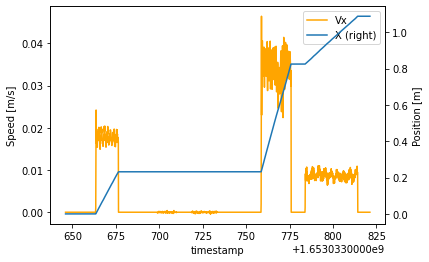

In [7]:
def get_recording_ground_truth(
        recording: Path, TUM_format: bool = False
    ) -> pd.DataFrame:
    ground_truth_path = recording / 'ground_truth.csv'
    if ground_truth_path.exists():
        gt = pd.read_csv(ground_truth_path, index_col='timestamp')
    else:
        gt = generate_recording_ground_truth(recording)
        gt.to_csv(ground_truth_path, index_label='timestamp')
    if TUM_format:
        gt['tx'] = gt['X'].diff()
        gt.drop(
            columns=['X', 'Vx', 'Vw', 'slip', 'wheel_rotation'], inplace=True
            )
        gt[['ty', 'tz', 'qw', 'qx', 'qy', 'qz']] = 0
        gt.iloc[0, :] = 0
    return gt


ground_truth = get_recording_ground_truth(recording=recording)
ax = ground_truth.plot(y=['Vx'], ylabel='Speed [m/s]', color='orange')
ground_truth.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [m]')
get_recording_ground_truth(recording=recording, TUM_format=True).head()

## Model definition

To be refactored into AO package.

In [8]:
from abc import abstractmethod

class AcousticOdometryModel(nn.Module):

    @abstractmethod
    def forward(self, x):
        pass

# Reset the subclasses to allow changes without restarting the kernel
for subclass in AcousticOdometryModel.__subclasses__():
    del subclass

In [9]:
class CNNet(AcousticOdometryModel):
    def __init__(self, classes: int):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(210816, 512)
        self.fc2 = nn.Linear(512, classes)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

In [10]:
AcousticOdometryModel.__subclasses__()

[__main__.CNNet]

## Apply model to recording

In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(DEVICE))

Using cuda device


In [12]:
def acoustic_odometry(wav_file: Path, model_path: Path) -> pd.DataFrame:
    model = torch.load(model_path)
    # TODO This should be loaded from the model configuration
    segment_duration = 1200  # [milliseconds]
    segment_overlap = 1000  # [milliseconds]
    frame_features = 256
    frame_duration = 10  # [milliseconds])
    extractor = ao.extractor.GammatoneFilterbank
    extractor_kwargs = {}
    compression = math.log10

    wav_data, sample_rate = ao.io.wave_read(wav_file)
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    start = config['start_timestamp']
    step = (segment_duration - segment_overlap) / 1000
    frame_samples = int(frame_duration * sample_rate / 1000)
    if compression:
        compression = np.vectorize(compression)
    extract = extractor(
        num_samples=frame_samples,
        num_features=frame_features,
        sample_rate=sample_rate,
        **extractor_kwargs
        )
    # TODO this should be done in a streaming fashion using a C++ interface
    segments = ao.dataset.audio.segment(
        wav_data, sample_rate, segment_duration, segment_overlap
        )
    timestamps = np.linspace(
        start, start + len(segments) * step, len(segments)
        )
    Vx = np.zeros(len(segments))
    for i, segment in enumerate(segments):
        # ! This is very inefficient as we are actually recomputing the
        # ! features from the overlapped segment which is 90% of its size
        features = torch.from_numpy(
            ao.dataset.audio.features(
                segment,
                frame_samples,
                extract=extract,
                compression=compression
                )[np.newaxis, np.newaxis, :, :]  # [batch, channel, w, h]
            ).float().to(DEVICE)
        Vx[i] = model(features).argmax(1).sum().item()
        # Free memory
        del features

    # Compute X translations and cumulative X position
    Vx = pd.Series(Vx, index=timestamps) / 100  # [cm/s] -> [m/s]
    odom = pd.concat([Vx, Vx.index.to_series().diff() * Vx], axis=1)
    odom.columns = ['Vx', 'tx']
    odom.iloc[0, :] = 0
    odom['X'] = odom['tx'].cumsum()
    return odom


odom = acoustic_odometry(
    wav_file=recording / f'microphone0.wav',
    model_path=MODELS_FOLDER /
    'name_numpy-arrays;date_2022-05-23;time_13-39-14.pt'
    )
odom.head()

,Vx,tx,X
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0


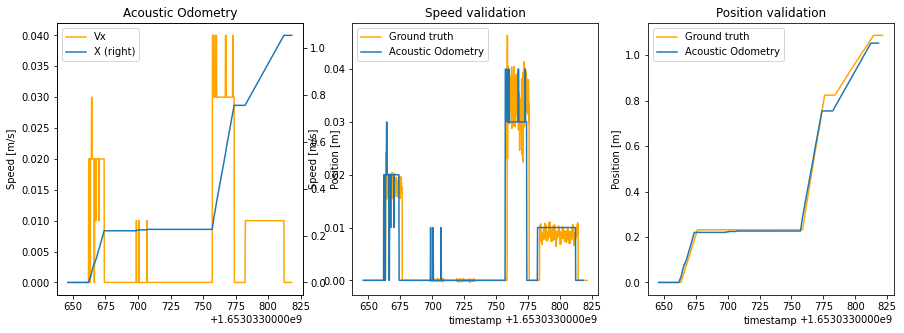

In [13]:
def plot_acoustic_odometry(odom: pd.DataFrame, ground_truth: pd.DataFrame):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_title('Acoustic Odometry')
    ax = odom.plot(ax=axs[0], y=['Vx'], ylabel='Speed [m/s]', color='orange')
    odom.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [m]')
    axs[1].set_title('Speed validation')
    ax = ground_truth.plot(
        ax=axs[1],
        y=['Vx'],
        ylabel='Speed [m/s]',
        color='orange',
        label=['Ground truth']
        )
    odom.plot(ax=ax, y=['Vx'], label=['Acoustic Odometry'])
    axs[2].set_title('Position validation')
    ax = ground_truth.plot(
        ax=axs[2],
        y=['X'],
        ylabel='Position [m]',
        color='orange',
        label=['Ground truth']
        )
    odom.plot(ax=ax, y=['X'], label=['Acoustic Odometry'])
    return fig, axs

_ = plot_acoustic_odometry(odom, ground_truth)

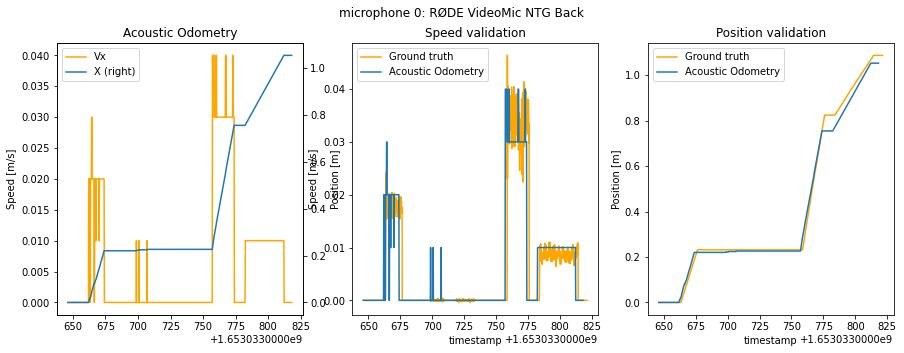

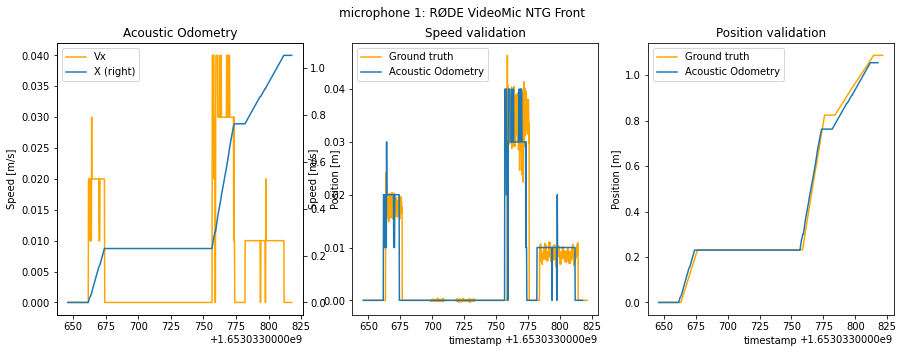

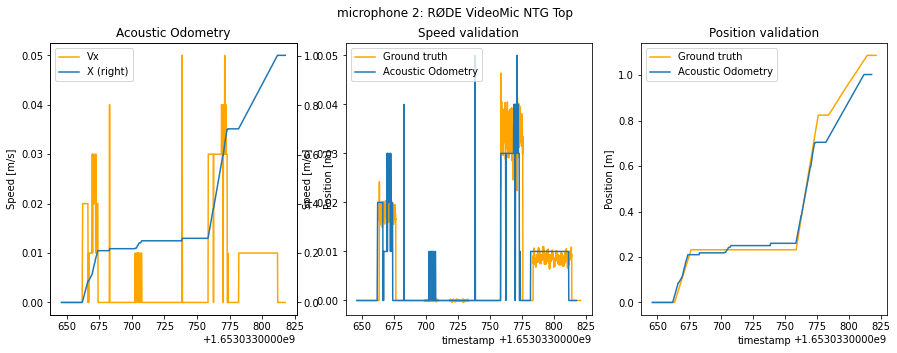

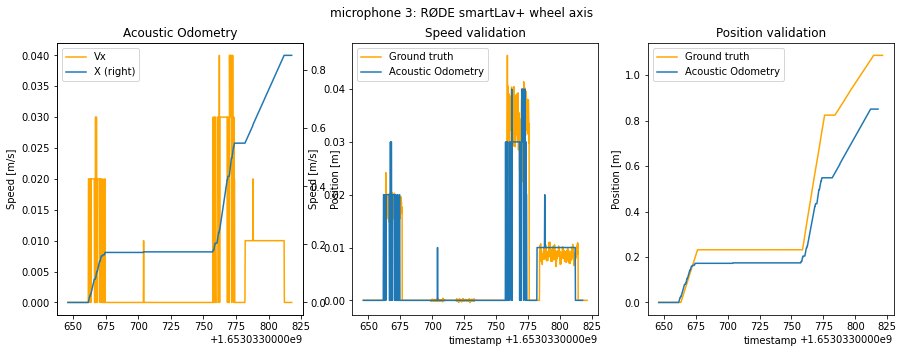

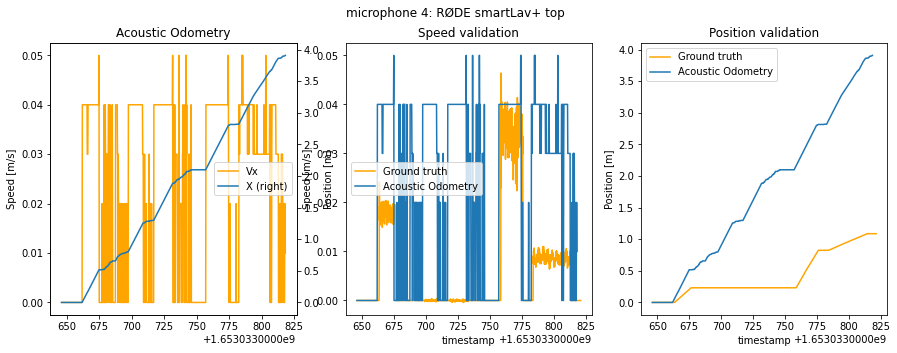

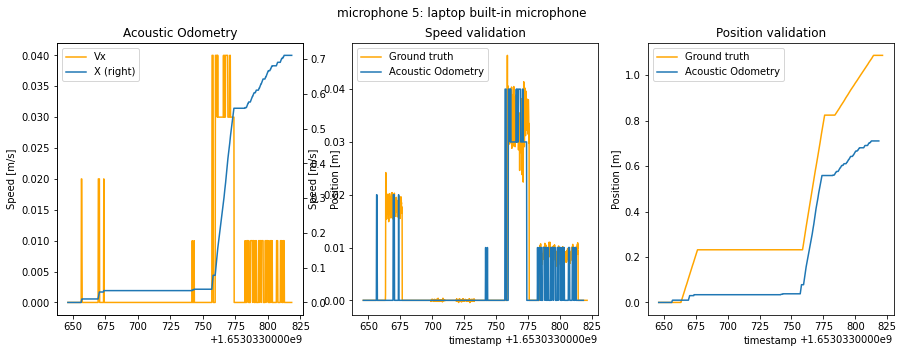

In [14]:
def validate_acoustic_odometry(recording: Path, microphone: int):
    ground_truth = get_recording_ground_truth(recording=recording)
    wav_file = recording / f'microphone{microphone}.wav'
    odom = acoustic_odometry(
        wav_file=wav_file,
        model_path=MODELS_FOLDER /
        'name_numpy-arrays;date_2022-05-23;time_13-39-14.pt'
        )
    fig, _ = plot_acoustic_odometry(odom, ground_truth)
    # Load config and set title
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    fig.suptitle(f"microphone {microphone}: {config['name']}")
    
validate_acoustic_odometry(recording=recording, microphone=0)
validate_acoustic_odometry(recording=recording, microphone=1)
validate_acoustic_odometry(recording=recording, microphone=2)
validate_acoustic_odometry(recording=recording, microphone=3)
validate_acoustic_odometry(recording=recording, microphone=4)
validate_acoustic_odometry(recording=recording, microphone=5)

## Evaluate the results

In [15]:
import tempfile
from evo.tools import file_interface

odom_TUM = odom.drop(['Vx', 'X'], axis=1)
odom_TUM[['ty', 'tz', 'qw', 'qx', 'qy', 'qz']] = 0
print(odom_TUM.head())

with tempfile.TemporaryDirectory() as folder:
    est_file = Path(folder) / 'est.csv'
    odom_TUM.to_csv(est_file, index_label='timestamp', sep=' ', header=False)
    traj_est = file_interface.read_tum_trajectory_file(est_file)
print(traj_est)

               tx  ty  tz  qw  qx  qy  qz
1.653034e+09  0.0   0   0   0   0   0   0
1.653034e+09  0.0   0   0   0   0   0   0
1.653034e+09  0.0   0   0   0   0   0   0
1.653034e+09  0.0   0   0   0   0   0   0
1.653034e+09  0.0   0   0   0   0   0   0
860 poses, 0.092m path length, 172.000s duration


In [16]:
_traj_ref = get_recording_ground_truth(recording=recording, TUM_format=True)
print(_traj_ref.head())
with tempfile.TemporaryDirectory() as folder:
    ref_file = Path(folder) / 'ref.csv'
    _traj_ref.to_csv(ref_file, index_label='timestamp', sep=' ', header=False)
    traj_ref = file_interface.read_tum_trajectory_file(ref_file)
print(traj_ref)

                   tx  ty  tz  qw  qx  qy  qz
timestamp                                    
1.653034e+09  0.00000   0   0   0   0   0   0
1.653034e+09  0.00000   0   0   0   0   0   0
1.653034e+09  0.00011   0   0   0   0   0   0
1.653034e+09  0.00118   0   0   0   0   0   0
1.653034e+09  0.00242   0   0   0   0   0   0
880 poses, 0.114m path length, 175.113s duration


In [17]:
from evo.core import sync

max_diff = 0.01

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)

In [18]:
from evo.core import metrics
from pprint import pprint


ape_metric = metrics.APE(metrics.PoseRelation.translation_part)
ape_metric.process_data((traj_ref, traj_est))

ape_stats = ape_metric.get_all_statistics()
pprint(ape_stats)
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]
fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

{'max': 0.0058069894790650466,
 'mean': 0.0013362599978171132,
 'median': 0.0010523274421691832,
 'min': 0.0,
 'rmse': 0.001978436840851638,
 'sse': 0.0004736196923219202,
 'std': 0.0014589796268189691}


NameError: name 'plot' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
rpe_metric = metrics.RPE(
    pose_relation=metrics.PoseRelation.translation_part,
    delta=1,
    delta_unit=metrics.Unit.frames,
    all_pairs=False
    )
rpe_metric.process_data((traj_ref, traj_est))

rpe_stats = rpe_metric.get_all_statistics()
pprint(rpe_stats)

In [ ]:
seconds_from_start = [
    t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]
    ]

fig = plt.figure()
plot.error_array(
    fig.gca(),
    rpe_metric.error,
    x_array=seconds_from_start,
    statistics={s: v
                for s, v in rpe_stats.items() if s != "sse"},
    name="RPE",
    title="RPE w.r.t. " + rpe_metric.pose_relation.value,
    xlabel="$t$ (s)"
    )
plt.show()